<a href="https://colab.research.google.com/github/fernanda-palacios/ai-code-notebooks/blob/main/d_loading_datasets_and_multiple_linear_regression_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Loading custom datasets with PyTorch





## Taking a look at the data



In [15]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(0)
df = pd.read_csv("d_Housing.csv") # Loading CSV data as a pandas dataframe
df = df.dropna()
df.head(5) # sample data

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [16]:
df.info() # summary of the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


## 1a. Writing a custom Dataset class for our dataset


In [17]:
class HousingDataset(Dataset): # Inherits from PyTorch Dataset class

    def __init__(self, csv_path: str) -> None:
        self.df = pd.read_csv(csv_path)
        self.df = self.df.dropna()
        self.df = self.df.drop(["furnishingstatus"], axis=1) # dropping furnishing because it is not a binary categorical
        self.x, self.y = self.dataframe_to_tensors(self.df)

        mean_x, mean_y = self.x.mean(dim = 1), self.y.mean(dim = 0)
        std_x, std_y = self.x.std(dim = 1), self.y.std(dim = 0)
        # normalize data
        self.x = (self.x - mean_x.view(11, 1)) / std_x.view(11, 1)
        self.y = (self.y - mean_y) / std_y


    def dataframe_to_tensors(self, df) -> tuple[torch.Tensor, torch.Tensor]:
        columns = list(df.columns)
        target = torch.tensor(df["price"], dtype=torch.float32)
        columns.remove("price")

        features = []
        for col_name in columns:
            feature = df[col_name]
            if feature.dtype == "int64":
                feature_tensor = torch.tensor(feature, dtype=torch.float32)
            else:
                boolean_mask = feature == "yes"
                feature_tensor = torch.tensor(boolean_mask, dtype=torch.float32)
            features.append(feature_tensor)

        # combine list of tensors into a single tensor of shape torch.Size([11, 545]), where the first dimension
        # represents the 11 features and the second represents individual data points.
        features = [x.unsqueeze(0) for x in features]
        features = torch.cat(features, dim=0)
        return features, target


    def __len__(self) -> int:
        return self.y.shape[0]


    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        return self.x[:, idx], self.y[idx]


housing_dataset = HousingDataset("d_Housing.csv")

## 1b. The DataLoader object
---



In [18]:
# Batching our data so that we can perform backpropagation on multiple instance of data in a single training iteration
# Shuffling these batches, so that we draw them in a different order each epoch
loader = DataLoader(dataset=housing_dataset, batch_size=32, shuffle=True)


#2. Multiple Linear Regression with PyTorch

Perform linear regression using gradient descent on a dataset with 11 input features and 1 output feature

##Creating and training our model

100%|██████████| 18/18 [00:00<00:00, 895.73it/s]


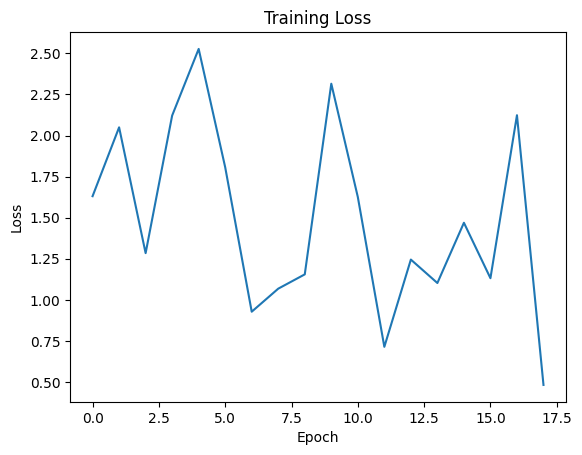

linear.weight Parameter containing:
tensor([[-0.0023,  0.1617, -0.2482, -0.2219, -0.1161,  0.0809, -0.0060,  0.2391,
         -0.0268,  0.0798, -0.0911]], requires_grad=True)
linear.bias Parameter containing:
tensor([-0.0593], requires_grad=True)


In [19]:
from torch import nn, optim
from tqdm import tqdm #display loading bars during iteration
import time
import matplotlib.pyplot as plt


class HousingPriceModel(nn.Module):

    def __init__(self):
        super(HousingPriceModel, self).__init__()
        self.linear = nn.Linear(11, 1)

    def forward(self, x):
        return self.linear(x)


model = HousingPriceModel()
crit = nn.MSELoss()
opt = optim.SGD(params=model.parameters(), lr=0.000000001)

losses = []

loop = tqdm(loader)
for x, y in loop:
    opt.zero_grad()
    yhat = model.forward(x).view(-1)
    loss = crit(yhat, y)
    loss.backward()
    opt.step()
    losses.append(loss.item())

# Plotting the loss curve
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.show()


# Print model's parameters
# 11 weights, 1 bias
for name, param in model.named_parameters():
  print(name, param)